### Extracting features - Finance analysis

### Features Extracted:

- https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira
    
Gerar features de um segmento "ESPECÍFICO" e "GLOBAIS".

### Importing data

In [73]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv
from salicml.utils.utils import debug

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

#### PLANILHA ORCAMENTARIA

QUERY: /data/scripts/planilha_orcamentaria.sql


In [74]:
PlanilhaOrcamentaria = 'planilha_orcamentaria.csv'
dt_items = read_csv(PlanilhaOrcamentaria)

dt_items.head()

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,UfItem,MunicipioItem,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
0,114166,93004,50109,Montagem e desmontagem,88,Serviço,2,1.0,2,140.00,...,PB,Sumé,2 - Produção / Execução,5,Patrimônio Cultural,51,História,62,Exposição de Artes,2009-06-26 09:46:54
1,123461,103228,239572,Locação de Piano,3040,Serviço,12,1.0,6,1500.00,...,RJ,Rio de Janeiro,2 - Produção / Execução,3,Música,33,Música Instrumental,51,Apresentação Musical,2010-05-06 10:49:13
2,123461,103228,239599,Programa,2634,Unidade,6,400.0,6,2.00,...,RJ,Rio de Janeiro,3 - Divulgação / Comercialização,3,Música,33,Música Instrumental,51,Apresentação Musical,2010-05-06 10:49:13
3,132803,1012471,86608,Transporte Local / Locação de Automóvel / Comb...,134,Metro 3 / Km,4,500.0,4,1.45,...,MG,Viçosa,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,51,Apresentação Musical,2010-12-21 17:09:22
4,115111,93932,11387,Confecção de painéis explicativos,90,Unidade,30,20.0,1,300.00,...,PE,Recife,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,62,Exposição de Artes,2009-07-27 08:40:04


In [75]:
dt_items = dt_items[['PRONAC', 'idPlanilhaAprovacao','idSegmento']]
dt_items.head()

,PRONAC,idPlanilhaAprovacao,idSegmento
0,93004,50109,51
1,103228,239572,33
2,103228,239599,33
3,1012471,86608,71
4,93932,11387,71


### FEATURES 
    - Numero de Itens do projeto.

# Dividindo pronacs de treino e pronacs de teste

50/50

In [76]:
from sklearn.model_selection import train_test_split


all_pronacs = dt_items.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=0.5)


dt_train = dt_items[dt_items['PRONAC'].isin(pronacs_train)]
dt_test = dt_items[dt_items['PRONAC'].isin(pronacs_test)]

In [77]:
print('pronacs_train = {}'.format(pronacs_train))
print('pronacs_test = {}'.format(pronacs_test))

assert (dt_train.shape[0] + dt_test.shape[0]) == dt_items.shape[0]

display(dt_train.head())
display(dt_test.head())

pronacs_train = [ 150350 1210252  128296 ...  163391  132178  132656]
pronacs_test = [ 127032  175926  148083 ... 1111307  151885  146938]


,PRONAC,idPlanilhaAprovacao,idSegmento
4,93932,11387,71
6,1012800,141238,71
9,146032,1224601,12
10,122413,560343,4B
16,109325,51766,12


,PRONAC,idPlanilhaAprovacao,idSegmento
0,93004,50109,51
1,103228,239572,33
2,103228,239599,33
3,1012471,86608,71
5,93004,50208,51


In [78]:
segment_projects = dt_train.groupby(['idSegmento', 'PRONAC']).count()
segment_projects.head()

idPlanilhaAprovacao
idSegmento PRONAC                     
11         98022                    17
           100855                   96
           104202                   57
           106879                   27
           107042                   71

### Plotando as distribuiçoes dos segmentos mais comuns

In [79]:
common_segements = segment_projects.groupby(['idSegmento']).count().sort_values(by='idPlanilhaAprovacao', ascending=False)
common_segements.rename(columns={'idPlanilhaAprovacao': 'Número de projetos'}, inplace=True)
display(common_segements.head())

,Número de projetos
idSegmento,
11,4814
31,2281
33,2153
4B,1329
12,1185


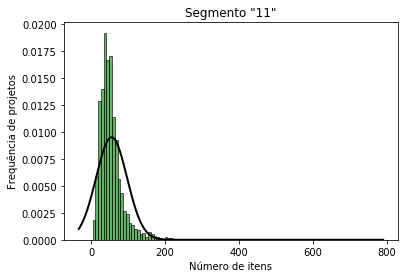

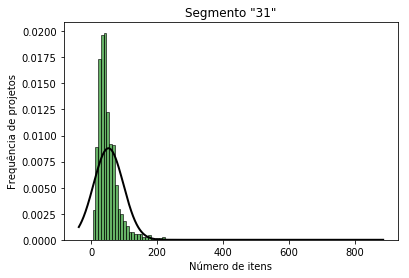

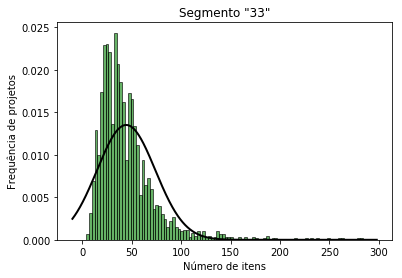

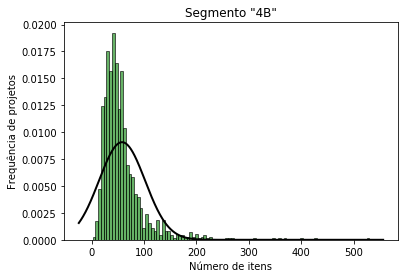

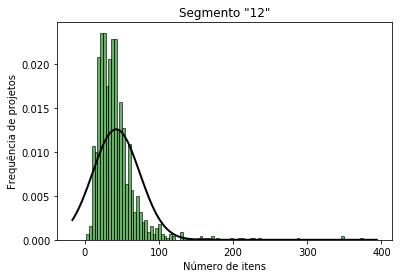

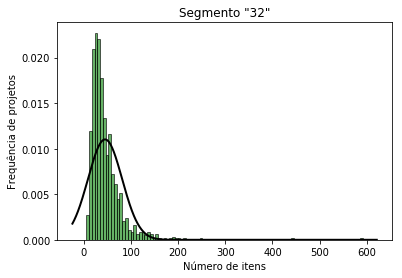

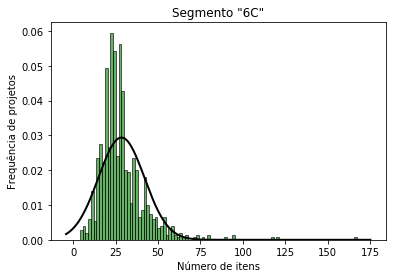

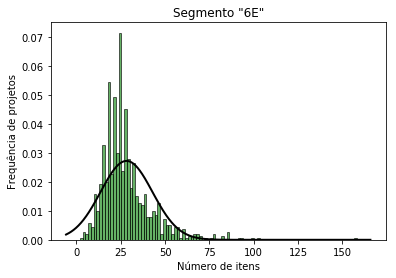

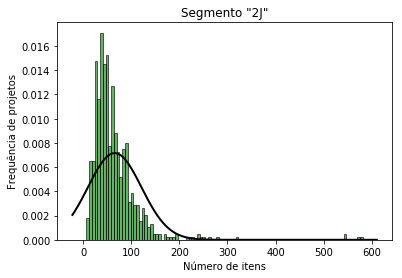

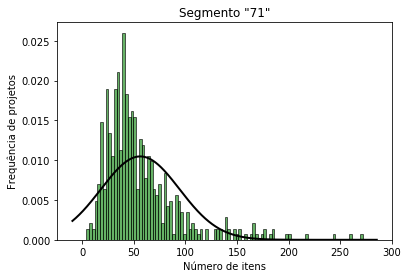

In [80]:
from scipy.stats import norm


def plot_segment(id, items):
    plt.hist(items, bins=100, density=True, alpha=0.6, color='g', edgecolor='black')
    plt.title('Segmento "{}"'.format(id))
    plt.xlabel('Número de itens')
    plt.ylabel('Frequência de projetos')

    mu, std = np.mean(items), np.std(items)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

for counter, id_segmento in enumerate(common_segements.index.values):    
    projects_num_items = segment_projects.loc[id_segmento].values
    plot_segment(id_segmento, projects_num_items)
    
    counter += 1
    if counter == 10:
        break

In [81]:
segment_items_avg_std = segment_projects.groupby(['idSegmento'])
segment_items_avg_std = segment_items_avg_std.agg(['count', 'sum', 'mean', 'std'])

segment_items_avg_std.columns = segment_items_avg_std.columns.droplevel(0)

segment_items_avg_std.head()

,count,sum,mean,std
idSegmento,,,,
11,4814,265873,55.229123,41.921345
12,1185,50095,42.274262,31.785412
13,190,9817,51.668421,41.764274
14,59,4110,69.661017,47.516099
15,1,66,66.000000,NaN


# Calculando a porcentagem de outliers no conjunto de teste

In [82]:
project_items_grp = dt_items.groupby(['PRONAC'])
project_items = project_items_grp.count().rename(columns={'idPlanilhaAprovacao': 'count'})
project_items.head()

,count,idSegmento
PRONAC,,
90105,61,61
90226,34,34
90335,26,26
90413,58,58
90722,33,33


In [83]:
from salicml.outliers.gaussian_outlier import is_outlier


def is_number_of_items_outlier(pronac):
    assert isinstance(pronac, int)
    num_items = project_items.loc[pronac]['count']
    id_segmento = project_items_grp.get_group(90105).iloc[0]['idSegmento']
    
    mean = segment_items_avg_std.loc[id_segmento]['mean']
    std = segment_items_avg_std.loc[id_segmento]['std']
    outlier = is_outlier(num_items, mean, std)
    return outlier

pronac = np.random.choice(dt_test.PRONAC.values)
is_number_of_items_outlier(90105)

False

In [84]:
from salicml.outliers.gaussian_outlier import outlier_probability


print(1 - outlier_probability(0.0, 1.0, c=1.5))

0.06680720126885809


In [85]:
pronacs_test = dt_test.PRONAC.unique()

outlier_arr = np.zeros(pronacs_test.size)

for i, pronac in enumerate(pronacs_test):
    outlier = is_number_of_items_outlier(int(pronac))
    outlier_arr[i] = 1.0 if outlier else 0.0
    
describe = pd.DataFrame(outlier_arr).describe()
display(describe)

,0
count,20578.000000
mean,0.040577
std,0.197314
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Análise dos resultados

Para `c = 1.5`, esperava-se que `6.68%` dos projetos fossem considerados outliers em termos dos números de itens por projeto. Para os conjuntos de treino e teste utilizados e `c = 1.5`, `3.71%`dos projetos foram considerados outliers.